# <a href="https://thetahat.ru/courses/ad">Введение в анализ данных</a>


## Сверточные сети (CNN)


На [прошлом занятии](https://thetahat.ru/courses/ad/main/4/nn_simple_examples) мы поняли, как использовать готовые модули из Pytorch и опробовали слои `nn.Linear`, `nn.ReLU` для создания полносвязной сети. В этом ноутбуке мы продолжим работать с Pytorch. Будем решать задачу классификации и сравним 2 подхода: полносвязная сеть (fully-connected NN или MLP) и сверточная сеть (CNN). Теорию можно посмотреть в [презентации](https://thetahat.ru/files/ad/main/5/lec5.pdf).

Чтобы все корректно отработало, этот ноутбук, как и в прошлый раз, нужно запускать в той среде, где есть графический процессор GPU. Бесплатно воспользоваться GPU можно в <a href="https://colab.research.google.com/?hl=ru" target="_blank">Google Colab</a> и [Kaggle](https://www.kaggle.com/). Однако учтите, что на данный момент доступ к GPU ограничен работой в несколько часов в сутки. Для того, чтобы подключиться к GPU в Colab, зайдите в меню `Среда выполнения`, выберите опцию `Сменить среду выполнения`. В списке аппаратных ускорителей выберите GPU.

In [1]:
# Установите библиотеки, если необходимо
# !pip install opencv-python
# !pip install -q torchinfo

In [2]:
import time
import warnings
from collections import defaultdict
from typing import Callable, Dict, List, Tuple, Optional, Union

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchinfo import summary
from torchvision.transforms.functional import to_tensor, rgb_to_grayscale
from torch.utils.data import DataLoader
import torchvision.models as models

from IPython.display import clear_output

sns.set(font_scale=1, style="darkgrid", palette="Set2")
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### 1. Convolution (свёртка)

#### 1.1. Описание свертки

**Изображение**

Цветная картинка — это матрица пикселей размером $H \times W$, где:
- $H$ — высота в пикселях,
- $W$ — ширина в пикселях.

Пиксель обычно представляется в RGB формате: массив интенсивностей для красного, зелёного и синего цветов. Каждая интенсивность — это число от 0 до 1, но чаще её кодируют числом от 0 до 255 (1 байт).

Цветная картинка представлена тензором размера $(H, W, 3)$, состоящим из чисел типа `uint8`.

В PyTorch для удобства изображения представляют в виде тензоров размера $(C, H, W)$, где $C$ — количество каналов. Для цветных изображений обычно $C = 3$. Это необходимо, потому что в PyTorch часто работают с батчами изображений, и представление тензора как $(C, H, W)$ удобно для обработки: каждый канал (например, красный, зелёный, синий) рассматривается как отдельный слой, что позволяет эффективнее организовывать вычисления и работу с большими данными.



**Свёртка в PyTorch**

В PyTorch свёртка реализуется через слой `nn.Conv2d`.

> Основные гиперпараметры:
> - **`in_channels`** (int): количество каналов во входном изображении.
> - **`out_channels`** (int): количество каналов после применения свёртки (количество ядер (фильтров), которые будут применяться).
> - **`kernel_size`** (int, tuple): размер сверточного ядра.
> - **`stride`** (int, tuple): шаг, с которым будет применяться свёртка. Значение по умолчанию — `1`.
> - **`padding`** (int, tuple): добавление дополнительных пикселей по краям изображения. Значение по умолчанию — `0`.
> - **`padding_mode`** (string, optional): принцип заполнения краёв. Значение по умолчанию — `'zeros'`.

**Пример использования**

Предположим, у нас есть изображение размером `1x5x5`, где:
- `1` — количество каналов (например, это может быть один канал серого изображения),
- `5` — высота изображения (5 пикселей),
- `5` — ширина изображения (5 пикселей).

Применим свёртку с параметрами:

```python
nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
```

Свёртка с такими параметрами работает следующим образом.
* Сначала паддинг (`padding=1`) добавляет слой нулевых пикселей (`padding_mode='zeros'`) по краям изображения, что позволяет фильтру захватывать информацию с краёв, не уменьшая размеры изображения слишком сильно.
* Далее фильтр размером 3x3 (`kernel_size=3`) применяется к блокам 3x3 пикселей, начиная с верхнего левого угла. На каждом шаге фильтр *поэлементно* умножает пиксели на свои веса и суммирует результаты. На очередном шаге фильтр сдвигается на два пикселя (при `stride=2`), что уменьшает размер выходного изображения.

 ![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides.gif?raw=true)


В общем случае берём `out_channels` фильтров размера `in_channels x kernel_size x kernel_size`. В итоге мы получаем `out_channels` выходных тензоров.


**Интуиция**

В полносвязных слоях (`Linear`) каждый нейрон текущего слоя соединён с каждым нейроном предыдущего слоя. В случае свёртки нейрон соединён только с ограниченной областью выхода предыдущего слоя. Эта область называется *рецептивным полем* (receptive field) нейрона.

Такой подход необходим из-за большой размерности входных данных. Например, если размер входного изображения $3 \times 224 \times 224$, то *каждый нейрон* в слое с полной связностью будет иметь $3 \times 224 \times 224 = 150\:528$ параметров, что крайне много. Чтобы уменьшить количество параметров и иметь возможность добавлять нелинейности, архитектуры обычно используют несколько свёрточных слоёв.


&#x2753; **Вопрос** &#x2753;

> К изображению `(3, 224, 224)` применяют свертку `nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)`.
>
> * Какой будет размер выходного изображения?
> * Сколько у данного слоя обучаемых параметров?

*Проверяем себя.* Для ответа на вопрос будем использовать библиотеку `torchinfo`. Метод `summary` данной библиотеки позволяет визуализировать основные характеристики нейронной сети.

In [3]:
model = nn.Sequential()
model.add_module(
    "conv", nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)
)

summary(model.to(device), (2, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [2, 64, 112, 112]         --
├─Conv2d: 1-1                            [2, 64, 112, 112]         4,864
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 122.03
Input size (MB): 1.20
Forward/backward pass size (MB): 12.85
Params size (MB): 0.02
Estimated Total Size (MB): 14.07

> **Размер выхода**
>    - После добавления по $2$ пикселя с каждой стороны изображения (`padding=2`) изображение имеет размер $(228, 228)$.
>    - При `stride=2` ядро $5 \times 5$ проходит по изображению с шагом два. Количество шагов: $\frac{228 - 5}{2} + 1 = 112$, где $1$ отвечает за первое применение свертки, а дробь — за количество возможных сдвигов.
>    - Всего применяется $64$ ядра (`out_channels=64`).
>
> Итоговый размер выхода: $(64, 112, 112)$ — $64$ канала, высота и ширина по $112$ пикселей.
>
> **Количество обучаемых параметров**
> 1. Параметры свертки:
>    - Количество весов для одного фильтра: $3 \times 5 \times 5 = 75$ (`in_channels x kernel_size x kernel_size`).
>    - Количество фильтров: $64$ (`out_channels`).
>    - Итого весов: $75 \times 64 = 4800$.
>
> 2. Параметры смещения:
>    - Для каждого фильтра добавляется один параметр смещения.
>    - Итого смещений: $64$.
>
> Получаем общее количество параметров: $4800 + 64 = 4864$.


**Общий вид формул**

В общем случае размер выхода по каждой размерности можно вычислить по следующей формуле
$$\text{Output Size} = \left\lfloor \frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1,$$

а количество параметров при этом равно
$$\text{Parameters} = (\text{Kernel Size} \times \text{Kernel Size} \times \text{In Channels} + 1) \times \text{Out Channels},$$

где:
* $\text{Input Size}$ — размер входного изображения (ширина или высота),
* $\text{Kernel Size}$ — размер ядра свертки,
* $\text{In Channels}$ — число входных каналов,
* $\text{Out Channels}$ — число выходных каналов (количество фильтров),
* $\text{Padding}$ — количество добавленных пикселей по краям изображения,
* $\text{Stride}$ — шаг свертки (на сколько пикселей сдвигается фильтр),
* $+1$ — параметр смещения (bias) для каждого фильтра.


#### 1.2. Пример

Посмотрим на то, как применение свёртки с определёнными фильтрами влияет на изображение и как будет меняться картинка в зависимости от фильтра.

Скачаем изображения с помощью утилиты `wget`.

In [4]:
!wget https://i01.fotocdn.net/s217/4ad56f83edb719b5/gallery_m/2956235713.jpg -O Lenna.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg

--2025-03-30 06:37:24--  https://i01.fotocdn.net/s217/4ad56f83edb719b5/gallery_m/2956235713.jpg
Resolving i01.fotocdn.net (i01.fotocdn.net)... 130.117.76.67
Connecting to i01.fotocdn.net (i01.fotocdn.net)|130.117.76.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77949 (76K) [image/jpeg]
Saving to: ‘Lenna.jpg’

Lenna.jpg           100%[===================>]  76.12K   228KB/s    in 0.3s    

2025-03-30 06:37:25 (228 KB/s) - ‘Lenna.jpg’ saved [77949/77949]

--2025-03-30 06:37:25--  https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190950 (186K) [image/jpeg]
Saving to: ‘Bikesgray.jpg’

Bikesgray.jpg       100%[===================>] 186.47K  --.-KB/s    in 0.06s   

2025-03-30 06:37:26 (3.22 MB/s) - ‘Bikesgray.

Посмотрим на эти изображения

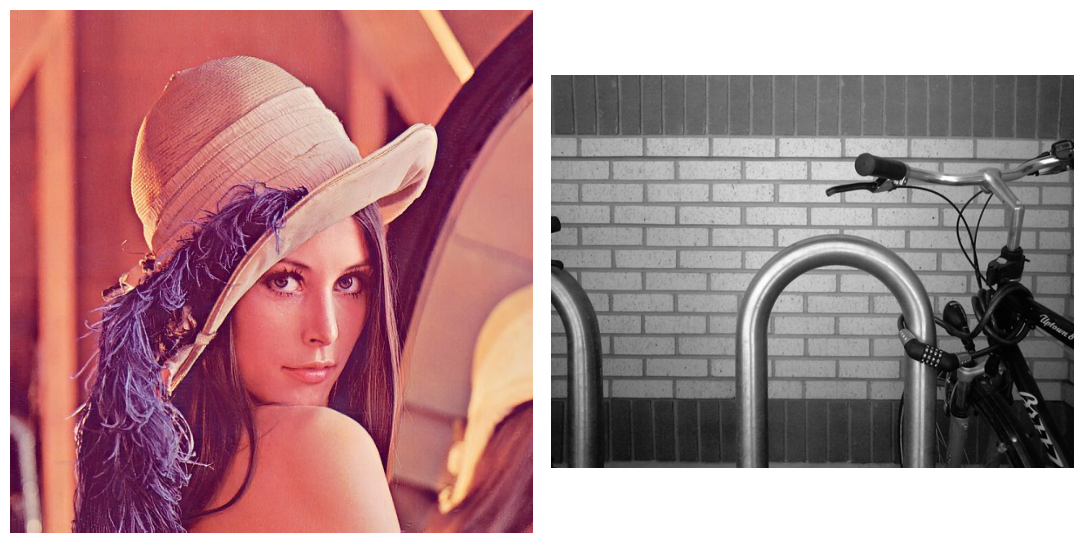

In [5]:
imgs = [plt.imread("Lenna.jpg"), plt.imread("Bikesgray.jpg")]

fig, axs = plt.subplots(1, 2, figsize=(11, 6))
axs[0].imshow(imgs[0])
axs[0].axis("off")
axs[1].imshow(imgs[1], cmap="gray")
axs[1].axis("off")
plt.tight_layout()

> Изображение **Lenna** — известный тестовый образ в обработке изображений. Оно взято в ноябре 1972 из одного известного журнала (название не указываем из этических соображений) и изображает шведскую модель **Лену Сёдерберг**. В 1973 году исследователи из Университета Южной Калифорнии использовали его для тестирования алгоритмов сжатия. Благодаря сложной текстуре и деталям, оно стало стандартом в научных исследованиях.
>
> Использование этого изображения вызвало споры из-за происхождения, но сама Лена в итоге поддержала его применение в науке. Несмотря на этические дискуссии, изображение до сих пор используется, а в 2019 году журнал официально разрешил использовать его для научных целей. Lenna называют "Моной Лизой обработки изображений" и даже включили в коллекцию Музея современного искусства (MoMA).

Функция для инициализации весов слоя.

In [6]:
def init_conv(kernel: torch.Tensor, kernel_size: int = 3, channels: int = 3) -> nn.Conv2d:
    """
    Инициализирует Conv2d с заданным ядром свертки.

    Параметры:
        kernel (torch.Tensor): Ядро свертки, которое будет использоваться для инициализации Conv2d.
        kernel_size (int): Размер ядра свертки (по умолчанию 3).
        channels (int): Количество каналов входного изображения (по умолчанию 3).

    Возвращает:
        nn.Conv2d: Сверточный слой, инициализированный заданным ядром.
    """
    # Преобразуем ядро в формат (channels, 1, kernel_size, kernel_size)
    kernel = kernel.view(1, 1, kernel_size, kernel_size).repeat(channels, 1, 1, 1)

    # Создаем сверточный слой для независимой свертки по каналам
    conv = nn.Conv2d(
        in_channels=channels,
        out_channels=channels,
        kernel_size=kernel_size,
        groups=channels,
        bias=False,
    )

    # Инициализируем веса свертки заданным ядром и отключаем градиенты
    conv.weight.data = torch.FloatTensor(kernel)
    conv.weight.requires_grad = False
    return conv

Функция для свертки изображения с одним фильтром.

In [7]:
def convolution(
    kernel: torch.Tensor,
    img: torch.Tensor,
    transforms: transforms.Compose,
    kernel_size: int = 3,
    channels: int = 3,
) -> torch.Tensor:
    """
    Применяет свертку с заданным ядром к изображению.

    Параметры:
        kernel (torch.Tensor): Ядро свертки.
        img (torch.Tensor): Входное изображение.
        transforms (transforms.Compose): Методы предобработки изображения.
        kernel_size (int): Размер ядра свертки (по умолчанию 3).
        channels (int): Количество каналов изображения (по умолчанию 3).

    Возвращает:
        torch.Tensor: Результат свертки, преобразованный в изображение с пикселями от 0 до 255.
    """
    # Предобработка изображению
    img_tensor = transforms(img)
    # Добавляем батч-размерность
    img_tensor = img_tensor.unsqueeze(0)

    # Инициализируем сверточный слой
    conv = init_conv(kernel, kernel_size=kernel_size, channels=channels)
    # Применяем свертку
    res = conv(img_tensor)

    # Убираем единичные размерности
    res = res.detach().squeeze()
    # Обрезаем значения до диапазона [0, 1]
    res = (torch.clip(res, 0, 1) * 255).int()

    return res

**Гауссовский фильтр**

Попробуем применить разные фильтры, чтобы продемонстрировать работу свертки. Начнем с гауссовского фильтра, который определяется как *плотность гауссовского распределения* в двухмерном случае, нормализованной так, чтобы сумма коэффициентов в фильтре была равна $1$.


$$G_{2D}(x, y, \sigma) = \frac{1}{2 \pi \sigma^2} \exp\left({-\frac{x^2 + y^2}{2 \sigma^2}}\right)$$

In [8]:
def get_gaussian_kernel(kernel_size: int = 15, sigma: float = 3) -> torch.Tensor:
    """
    Вычисляет гауссовское ядро для свертки.

    Параметры:
        kernel_size (int): Размер ядра (по умолчанию 15).
        sigma (float): Стандартное отклонение гауссовского распределения (по умолчанию 3).

    Возвращает:
        torch.Tensor: Нормализованное гауссовское ядро.
    """
    # Создаем сетку координат x, y, размер shape=(kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    # Вычисляем среднее значение для центра ядра
    mean = (kernel_size - 1) / 2.0
    variance = sigma**2.0

    # Вычисляем гауссовское ядро
    gaussian_kernel = (1.0 / (2.0 * np.pi * variance)) * torch.exp(
        -torch.sum((xy_grid - mean) ** 2.0, dim=-1) / (2 * variance)
    )

    # Нормализуем ядро, чтобы сумма значений равнялась 1
    return gaussian_kernel / torch.sum(gaussian_kernel)

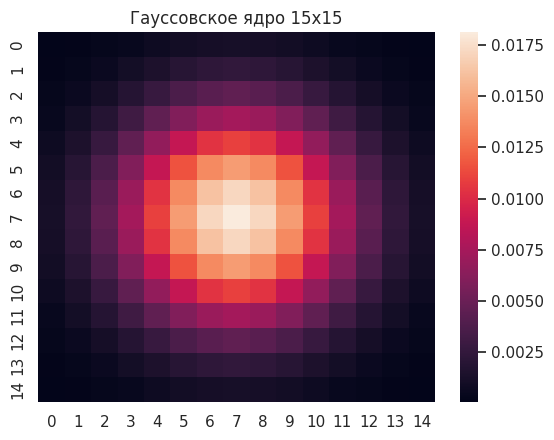

In [9]:
kernel_size = 15  # Размер ядра
gaussian_kernel = get_gaussian_kernel(kernel_size)

sns.heatmap(gaussian_kernel)
plt.title("Гауссовское ядро 15x15");

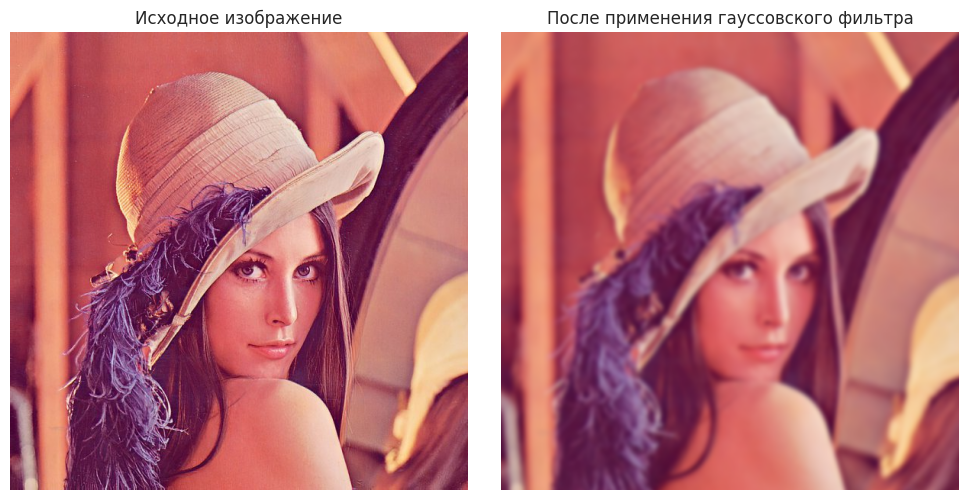

In [10]:
res = convolution(gaussian_kernel, imgs[0], transforms.ToTensor(), kernel_size=kernel_size)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(imgs[0])
axs[0].set_title("Исходное изображение")
axs[0].axis("off")
axs[1].imshow(res.permute(1, 2, 0))
axs[1].set_title("После применения гауссовского фильтра")
axs[1].axis("off")
plt.tight_layout()

Видим, что картинка размылась. Не зря так часто мы слышим выражение "Gaussian Blur".

**Оператор Собеля (выделение границ)**

Рассмотрим [оператор Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F). Он вычисляет градиент яркости изображения в каждой точке. Так находится направление наибольшего увеличения яркости и величина её изменения в этом направлении. Результат показывает, насколько «резко» или «плавно» меняется яркость изображения в каждой точке, а значит, вероятность нахождения точки на грани, а также ориентацию границы.

* Матрица Собеля для градиента по горизонтали
$G_x = \begin{pmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{pmatrix}$

* Матрица Собеля для градиента по вертикали
$G_y = \begin{pmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{pmatrix}$

Эти матрицы применяются к изображению с помощью операции свертки, чтобы выделить границы объектов на изображении.

In [11]:
kernel_size = 3  # Размер ядра
sobel_x = torch.FloatTensor([[[[1, 0, -1], [2, 0, -2], [1, 0, -1]]]])
sobel_y = torch.FloatTensor([[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]])

Numpy-картинку нужно привести к torch-тензору. Кроме того, для визуализации нам нужно отобразить картинку в черно-белом цвете. Это можно сделать с помощью модуля `transforms`.

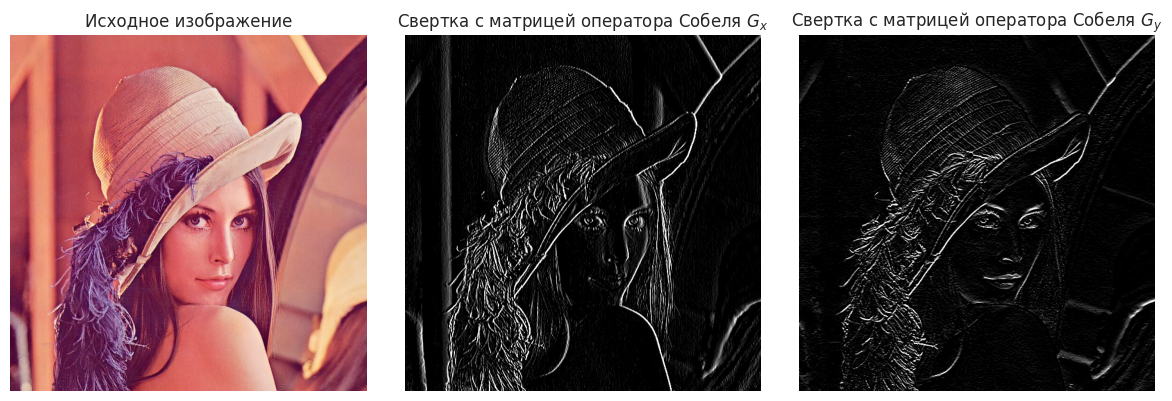

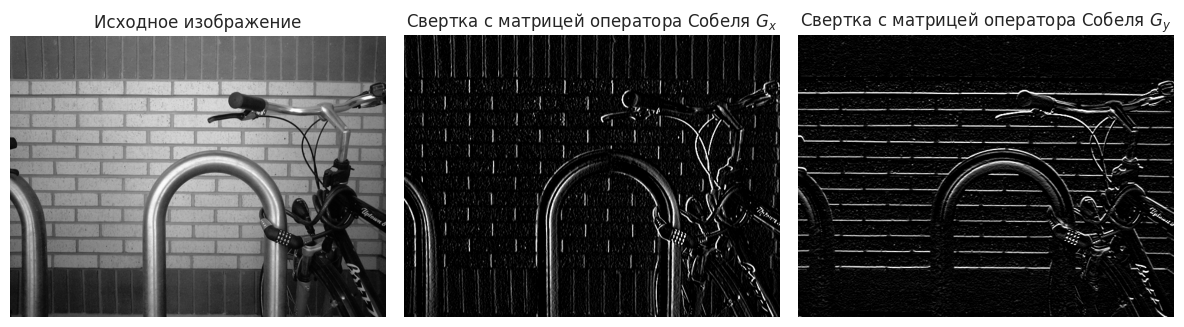

In [12]:
transform_bw = transforms.Compose(
    [
        transforms.ToTensor(),  # Переводим массив в торч-тензор
        transforms.Grayscale(),  # Делаем изображение черно-белым
    ]
)

res_images = []
for i, img in enumerate(imgs):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True, sharex=False)

    axs[0].imshow(img, cmap="gray" if i == 1 else None)
    axs[0].set_title("Исходное изображение")
    axs[0].axis("off")
    res_images.append([])

    for j, kernel in enumerate([sobel_x, sobel_y]):

        # Применяем оператор Собеля к изображению
        res = convolution(kernel, img, transform_bw, kernel_size=kernel_size, channels=1)

        # Отображаем результат
        axs[j + 1].imshow(res, cmap="gray")
        axs[j + 1].axis("off")
        res_images[-1].append(res)

    axs[1].set_title(r"Свертка с матрицей оператора Собеля $G_x$")
    axs[2].set_title(r"Свертка с матрицей оператора Собеля $G_y$")
    plt.tight_layout()

Чем пиксель более светлый, тем больше его значение. Если присмотреться, то можно заметить, как на первом результате фильтр делает более значимыми пиксели, соответствующие вертикальным линиям: нос, полоска справа, волосы, а на втором &mdash; горизонтальным: брови, губы.

Это как раз согласуется со значениями в фильтрах: первый вычисляет перепады значений в пикселях по вертикали, второй &mdash; по горизонтали.

С помощью этих фильтров легко прийти к методу выделения границ на изображении: поскольку каждая граница состоит из $x$ и $y$ компоненты, то используем теорему Пифагора и вычислим суммарное значение:
$$G = \sqrt{G_x^2 + G_y^2}$$

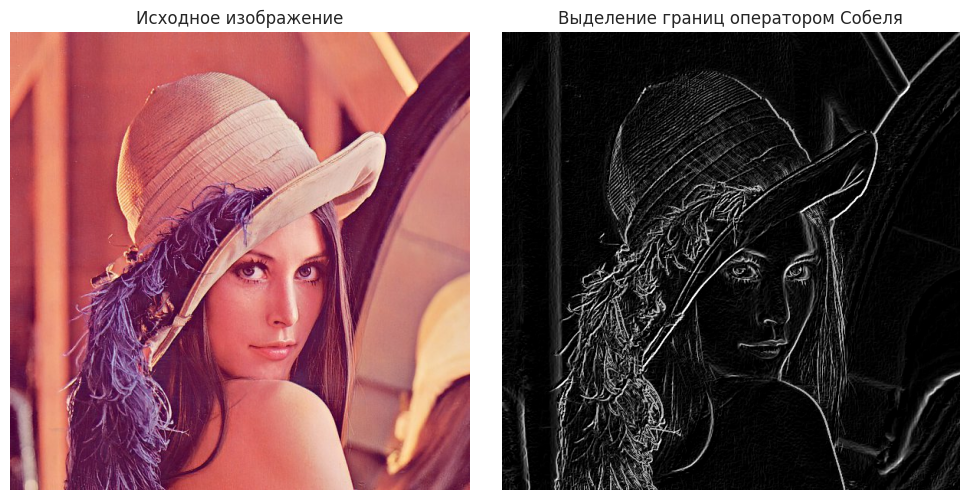

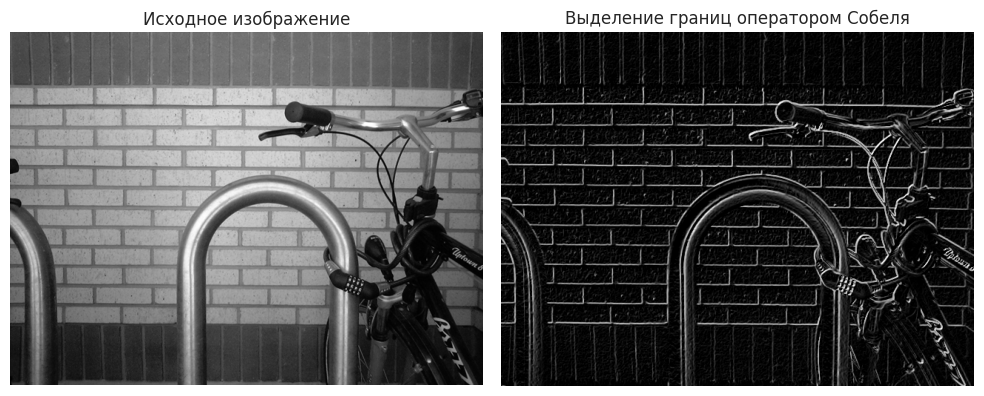

In [13]:
for i, img in enumerate(imgs):

    img_sobel = np.sqrt(res_images[i][0] ** 2 + res_images[i][1] ** 2)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, sharex=False)

    axs[0].imshow(img, cmap="gray" if i == 1 else None)
    axs[0].set_title("Исходное изображение")
    axs[0].axis("off")

    axs[1].imshow(img_sobel, cmap="gray")
    axs[1].set_title("Выделение границ оператором Собеля")
    axs[1].axis("off")

    plt.tight_layout()

### 2. Pooling

Pooling-слои используются для уменьшения размерности изображения, что позволяет снизить вычислительную сложность и предотвратить переобучение.

**Основные гиперпараметры**

> - **`kernel_size`** (int, tuple): размер ядра, которое применяется к изображению. Определяет область, по которой берётся максимум или среднее значение.
> - **`stride`** (int, tuple): шаг, с которым окно перемещается по изображению. Если не указан, по умолчанию равен `kernel_size`.
> - **`padding`** (int, tuple): количество нулевых пикселей, добавляемых по краям изображения перед применением pooling-операции.

**Основные виды pooling-операций**

1. **`MaxPooling`**  
   Берется максимальное значение из элементов, попавших в область ядра. Это позволяет выделить наиболее значимые признаки на изображении.

2. **`AveragePooling`**  
   Берется среднее значение из элементов, попавших в область ядра. Это помогает сгладить данные и уменьшить влияние шума.

**Интуиция**

Pooling-слои снижают размерность изображения, уменьшая количество параметров и, как следствие, вычислительную сложность модели. Это также помогает модели стать более устойчивой к небольшим изменениям в данных (например, сдвигам или поворотам изображения).

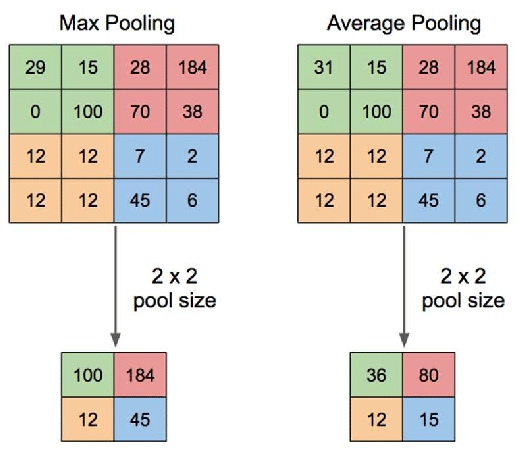

Продемонстрируем работу MaxPooling на нескольких изображениях с разными размерами окон

Напишем функцию для этого:

In [14]:
def visualize_pooling_multiple_scales(
    image: Union[torch.Tensor, np.ndarray],
    figsize: Tuple[int, int] = (15, 10),
    pooling_type: str = "max",
) -> None:
    """
    Визуализирует работу операции Pooling (MaxPooling или AvgPooling) на изображении с разными размерами окон.

    Параметры:
        image (Union[torch.Tensor, np.ndarray]): Входное изображение в формате (H, W, C) или (C, H, W).
        figsize (Tuple[int, int]): Размер фигуры для визуализации (по умолчанию (15, 10)).
        pooling_type (str): Тип Pooling: "max" для MaxPooling или "avg" для AvgPooling (по умолчанию "max").
    """
    # Проверяем тип изображения и преобразуем его в тензор, если необходимо
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image).permute(2, 0, 1).to(torch.float32)
    elif isinstance(image, torch.Tensor):
        if image.dim() == 3 and image.shape[0] != 3:  # Если формат (H, W, C), меняем оси
            image = image.permute(2, 0, 1)
    else:
        raise TypeError("Неподдерживаемый тип изображения. Ожидается torch.Tensor или np.ndarray.")

    print(f"Исходное изображение размера: {image.shape}")

    # Размеры окон Pooling, которые хотим визуализировать
    pool_sizes = [2, 4, 8]

    # Словарь для хранения результатов
    pooled_images = {}

    # Создаем фигуру для визуализации с сеткой 1x4
    fig, axes = plt.subplots(1, 4, figsize=figsize)

    # Исходное изображение
    axes[0].imshow(image.permute(1, 2, 0).to(torch.int64))
    axes[0].set_title(f"Исходное изображение ({image.shape[1]}x{image.shape[2]})")
    axes[0].axis("off")

    # Проверяем тип Pooling
    if pooling_type not in ("max", "avg"):
        raise NotImplementedError("pooling_type должен быть 'max' или 'avg'")
    pooling = F.max_pool2d if pooling_type == "max" else F.avg_pool2d
    pooling_name = "MaxPooling" if pooling_type == "max" else "AvgPooling"

    # Применяем Pooling с разными размерами окон и визуализируем результаты
    for i, pool_size in enumerate(pool_sizes):
        # Применяем Pooling
        pooled_image = pooling(image.unsqueeze(0), kernel_size=pool_size, stride=pool_size)[0]
        pooled_images[pool_size] = pooled_image

        print(f"После {pooling_name} {pool_size}x{pool_size} размер: {pooled_image.shape}")

        # Визуализируем результат
        axes[i + 1].imshow(pooled_image.permute(1, 2, 0).to(torch.int64))
        axes[i + 1].set_title(
            f"{pooling_name} {pool_size}x{pool_size} ({pooled_image.shape[1]}x{pooled_image.shape[2]})"
        )
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

Уменьшим размер изображения для визуализации

MaxPooling
Исходное изображение размера: torch.Size([3, 32, 32])
После MaxPooling 2x2 размер: torch.Size([3, 16, 16])
После MaxPooling 4x4 размер: torch.Size([3, 8, 8])
После MaxPooling 8x8 размер: torch.Size([3, 4, 4])


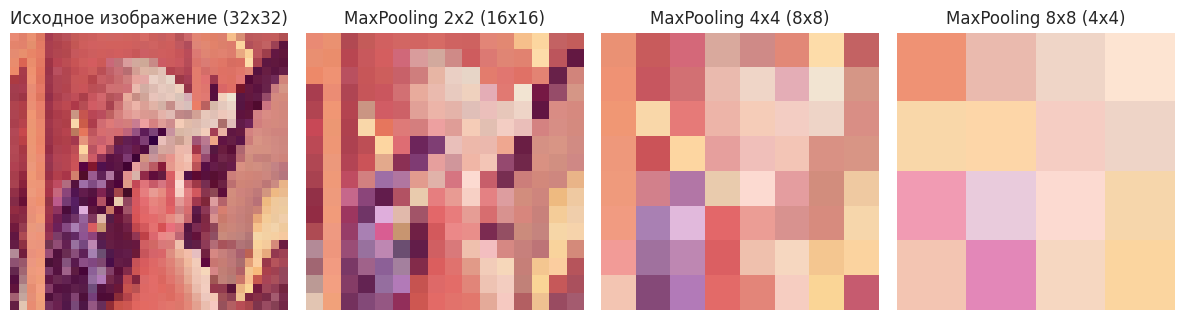

AvgPooling
Исходное изображение размера: torch.Size([3, 32, 32])
После AvgPooling 2x2 размер: torch.Size([3, 16, 16])
После AvgPooling 4x4 размер: torch.Size([3, 8, 8])
После AvgPooling 8x8 размер: torch.Size([3, 4, 4])


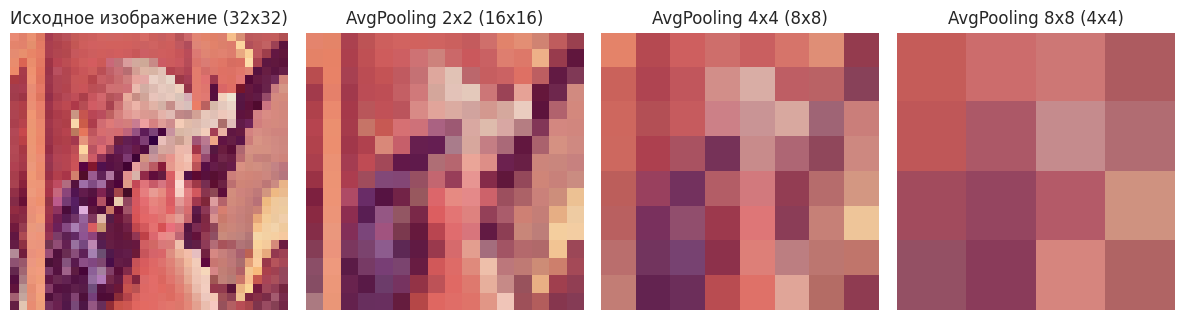

In [15]:
small_img = cv2.resize(imgs[0], (32, 32))

print("MaxPooling")
visualize_pooling_multiple_scales(small_img, figsize=(12, 6), pooling_type="max")

print("AvgPooling")
visualize_pooling_multiple_scales(small_img, figsize=(12, 6), pooling_type="avg")

### 3. Классификация изображений

####  3.1. Датасет CIFAR10

CIFAR-10 (Canadian Institute For Advanced Research) — это популярный датасет, который широко используется для демонстрации задач классификации изображений. Он состоит из 60 000 цветных изображений размером 32x32 пикселя, каждое из которых принадлежит одному из 10 классов.

* **Общее количество изображений**: 60 000.
* **Размер изображений**: 32x32 пикселя, цветные (3 канала: RGB).
* **Классы**: 10 классов, каждый из которых представляет отдельную категорию объектов. Классы показаны на картинке ниже.

* **Обучающая выборка**: 50 000 изображений (по 5 000 изображений на каждый класс).
* **Тестовая выборка**: 10 000 изображений (по 1 000 изображений на каждый класс).

Небольшой размер изображений, сбалансированность классов, а также разнообразие данных, делает его подходящим для тестирования свёрточных нейронных сетей.

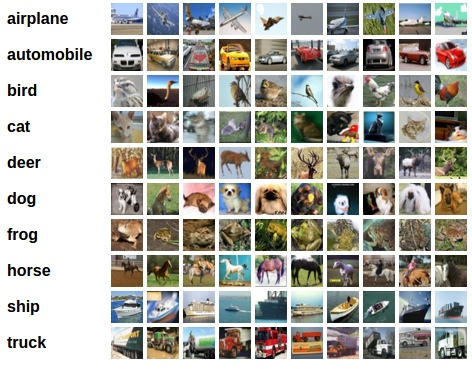

Загрузим его из коллекции датасетов библиотеки `torchvision` в RAM.

In [16]:
# Данные для обучения
train_dataset = torchvision.datasets.CIFAR10(
    root="./cifar", download=True, train=True, transform=transforms.ToTensor()
)

# Данные для тестирования
val_dataset = torchvision.datasets.CIFAR10(
    root="./cifar", download=True, train=False, transform=transforms.ToTensor()
)

# Классы объектов в датасете
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

100%|██████████| 170M/170M [00:03<00:00, 44.4MB/s]


Отметим, что датасеты из `torchvision` являются объектами типа `torch.utils.data.Dataset`. Это позволяет использовать их с удобными инструментами из `torch.utils.data`.

In [17]:
isinstance(train_dataset, torch.utils.data.Dataset)

True

Проверим размеры датасетов.

In [18]:
len(train_dataset), len(val_dataset)

(50000, 10000)

Визуализируем по картинке из каждой части датасета.

Размер картинки:torch.Size([3, 32, 32])


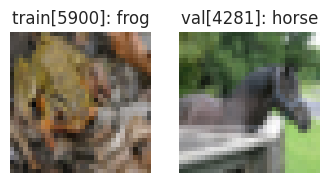

In [19]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

#### 3.2. Data Loader / Генератор батчей

В этот раз мы имеем дело с большим количеством данных, и пропускать весь набор через модель за один раз было бы неразумно. Гораздо эффективнее тренировать модель постепенно, разбивая набор на небольшие части (*батчи*). Для этого нам потребуется *генератор батчей*.

В PyTorch предусмотрен универсальный класс [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), который представляет собой гибкий генератор батчей. Он способен работать с различными типами датасетов, а также поддерживает перемешивание данных при семплировании и многопроцессорность, что делает его очень удобным в использовании.

> **Важные аргументы:**
>
> - **`dataset`** &mdash; объект типа [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) или [`torch.utils.data.IterableDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset), из которого будем семплировать.
> - **`batch_size`** (int) &mdash; размер батча.
> - **`shuffle`** (bool) &mdash; перемешивать ли данные.
> - **`num_workers`** (int) &mdash; количество параллельных процессов. Выдаст предупреждение, если указать больше workers, чем допустимо на вашей системе. *Установите значение `-1`, чтобы использовать максимально возможное количество.*
>
> **Использование:**
> ```
> for X_batch, y_batch in dataloader:
>     <...>
> ```
> Здесь `X_batch`, `y_batch` &mdash; объекты размера `batch_size`. Цикл проходит по всему датасету в определенном порядке, пока не закончится объекты в датасете. То есть каждый объект будет возвращен ровно 1 раз.
>
> Важные особенности:
> * Обучающую выборку принято передавать в перемешанном (`shuffle=True`) виде, это увеличивает обобщающую способность модели и уменьшает переобучение.
>
> * Тестовую выборку не перемешивают! Ведь обучение модели уже завершено, и порядок данных не влияет на результат.


Инициализируем `DataLoader` для наших частей датасета

In [20]:
batch_size = 64  # размер батча

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### 3.3. Функции для обучения модели

Стандартный цикл обучения на Pytorch:

```
for i in range(num_epochs):
    y_pred = model(x)               # forward pass
    loss = loss_function(y_pred, y) # вычисление лосса
    loss.backward()                 # backward pass
    optimizer.step()                # шаг оптимизации
    optimizer.zero_grad()           # зануляем градиенты
```

Такой цикл мы использовали в <a href="https://thetahat.ru/courses/ad/main/4/nn_simple_examples">прошлый раз</a>.

В этот раз мы будем обучать несколько моделей, а также визуализировать историю. Для упрощения процесса все необходимые действия мы поместили в функцию `train`. Она выполняет следующие функции:

1. Записывает лосс и метрики в `history`, а также измеряет время, затраченное на каждую эпоху.
2. На каждой эпохе выполняет два этапа:
   – **Обучение модели**: Полный проход по `train` датасету с подсчетом лосса и точности на каждой итерации.
   – **Валидация модели**: Полный проход по `val` датасету, также с подсчетом лосса и точности на каждой итерации.

> Бывают **слои, поведение которых отличается при обучении и тестировании**. Переключать режим модели можно с помощью `model.train(True)` и `model.train(False)` (эквивалентно `model.eval()`). *Такие слои появятся на 3 курсе, но приучиться менять режим стоит сразу.*
>
> Для ускорения работы и предотвращения ошибок в процессе валидации принято использовать `with torch.no_grad()`. Эта обертка говорит Pytorch, что в данный момент не нужно вычислять градиенты, что значительно ускоряет вычисления и снижает вероятность возникновения ошибок.

In [21]:
def plot_histories(histories: List[Dict[str, Dict[str, list]]], names: List[str]) -> None:
    """
    Визуализирует лосс и точность для нескольких моделей на одном графике.

    Параметры:
        histories (List[Dict[str, Dict[str, list]]]): Список историй обучения моделей.
            Каждая история должна содержать ключи "loss" и "acc" с подключами "train" и "val".
        names (List[str]): Список названий моделей для легенды.

    Возвращает:
        None
    """
    # Устанавливаем стиль "darkgrid" только для текущего графика
    with sns.axes_style("darkgrid"):
        # Цвета для графиков
        colors = ["darkblue", "lightcoral", "limegreen", "sandybrown"]

        # Создаем фигуру с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # Определяем количество эпох для отображения (минимальное среди всех историй)
        epochs = np.min([len(h["loss"]["train"]) for h in histories])

        # Построение графиков для каждой модели
        for i, (history, name) in enumerate(zip(histories, names)):
            # График лосса
            axs[0].set_title("Лосс")
            axs[0].plot(
                history["loss"]["train"][:epochs],
                label=f"{name}",
                lw=2,
                c=colors[i],
                ls="--",
            )
            axs[0].plot(
                history["loss"]["val"][:epochs],
                lw=1.5,
                c=colors[i],
            )
            axs[0].set_xlabel("Номер эпохи")

            # График точности
            axs[1].set_title("Точность классификации")
            axs[1].plot(
                history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i], ls="--"
            )
            axs[1].plot(history["acc"]["val"][:epochs], lw=1.5, c=colors[i])
            axs[1].set_xlabel("Номер эпохи")
            axs[1].legend()

        # Создаем фиктивные линии для легенды (train и val)
        dummy_lines = [
            axs[0].plot([], [], c="black", lw=2, ls="--")[0],
            axs[0].plot([], [], c="black", lw=1.5)[0],
        ]

        # Добавляем легенду для типов линий (train и val)
        for i in range(2):
            legend = axs[i].legend(loc=3 - i)  # Легенда для моделей
            axs[i].legend(dummy_lines, ["train", "val"], loc=4)  # Легенда для типов линий
            axs[i].add_artist(legend)  # Добавляем обе легенды на график

        plt.show()


def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Эпоха {} из {}, затраченное время {:.3f} сек.".format(epoch + 1, num_epochs, t))
    print("  лосс на обучении: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  лосс на валидации: \t{:.6f}".format(history["loss"]["val"][-1]))
    print("  точность на обучении: \t\t{:.2f} %".format(history["acc"]["train"][-1] * 100))
    print("  точность на валидации: \t\t{:.2f} %".format(history["acc"]["val"][-1] * 100))

    # Строим графики лосса и точности
    plot_histories([history], ["Model"])


def update_history(
    history: Dict[str, Dict[str, list]], loss: float, acc: float, num_batches: int, mode: str
) -> None:
    """
    Обновляет историю обучения, добавляя в нее loss и accuracy для текущей эпохи.

    Параметры:
        history (Dict[str, Dict[str, list]]): Словарь с историей обучения.
        loss (float): Суммарный loss за эпоху.
        acc (float): Суммарная точность за эпоху.
        num_batches (int): Количество батчей в эпохе.
        mode (str): Режим обучения ("train" или "val").
    """
    # Нормализуем loss и accuracy по количеству батчей
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch: torch.Tensor,
    y_batch: torch.Tensor,
    model: nn.Module,
    criterion: Callable,
    current_loss: float,
    current_acc: float,
) -> Tuple[torch.Tensor, float, float]:
    """
    Вычисляет loss и accuracy для одного батча (без backward pass).

    Параметры:
        X_batch (torch.Tensor): Батч входных данных.
        y_batch (torch.Tensor): Батч меток.
        model (nn.Module): Модель для обучения (выдает логиты).
        criterion (Callable): Функция потерь.
        current_loss (float): Текущий лосс за батч.
        current_acc (float): Текущая точность за батч.

    Возвращает:
        Tuple[torch.Tensor, float, float]: Лосс на батче, обновленные суммарные loss и accuracy.
    """
    # Перемещаем данные на устройство (GPU/CPU)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Получаем логиты от модели
    logits = model(X_batch)

    # Вычисляем loss
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: optim.Optimizer,
    train_batch_gen: DataLoader,
    val_batch_gen: DataLoader,
    num_epochs: int = 40,
) -> Dict[str, Dict[str, list]]:
    """
    Обучает модель и возвращает историю обучения.

    Параметры:
        model (nn.Module): Модель для обучения.
        criterion (Callable): Функция потерь.
        optimizer (optim.Optimizer): Оптимизатор.
        train_batch_gen (DataLoader): Генератор батчей для обучения.
        val_batch_gen (DataLoader): Генератор батчей для валидации.
        num_epochs (int): Количество эпох (по умолчанию 40).

    Возвращает:
        Dict[str, Dict[str, list]]: История обучения, содержащая loss и accuracy для обучения и валидации.
    """
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:

            # Вычисляем loss и accuracy для батча
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход, вычисление градиентов
            loss.backward()
            # Шаг градиентного спуска для обновления оценок весов
            optimizer.step()
            # Зануление градиентов
            optimizer.zero_grad()

        # Обновляем историю обучения
        update_history(history, train_loss, train_acc, len(train_batch_gen), "train")

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)

        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Вычисляем loss и accuracy для батча
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Обновляем историю валидации
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Выводим информацию о текущей эпохе
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

#### 3.4. Multi-Layer Perceptron Baseline

Начнем с простой нейросети-MLP из линейных слоев и функций активации, рассмотренной на <a href="https://thetahat.ru/courses/ad/main/4/nn_simple_examples">прошлом занятии</a> по нейросетям:

In [22]:
simple_mlp = nn.Sequential(
    # расплющиваем картинку (C, H, W) в вектор (C * H * W, )
    nn.Flatten(),
    nn.Linear(in_features=3 * 32 * 32, out_features=192),
    # без функции активации модель будет линейной и глупой :(
    nn.ReLU(),
    nn.Linear(in_features=192, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    # логиты (logits) для 10 классов
    nn.Linear(in_features=32, out_features=10),
).to(device)

Можно посмотреть количество параметров модели и размерность на промежуточных этапах с помощью `torchinfo.summary(model, input_size)`. Это также удобный инструмент для проверки правильности размерностей, так как их несовпадение может привести к ошибке.

In [23]:
summary(simple_mlp, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 3072]                 --
├─Linear: 1-2                            [1, 192]                  590,016
├─ReLU: 1-3                              [1, 192]                  --
├─Linear: 1-4                            [1, 64]                   12,352
├─ReLU: 1-5                              [1, 64]                   --
├─Linear: 1-6                            [1, 32]                   2,080
├─ReLU: 1-7                              [1, 32]                   --
├─Linear: 1-8                            [1, 10]                   330
Total params: 604,778
Trainable params: 604,778
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.60
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.42
Estimated Total Size (MB): 2.43

Применим ее к нашим данным $-$ картинкам из CIFAR10:

Эпоха 40 из 40, затраченное время 8.607 сек.
  лосс на обучении: 	1.198327
  лосс на валидации: 	1.679480
  точность на обучении: 		57.24 %
  точность на валидации: 		42.64 %


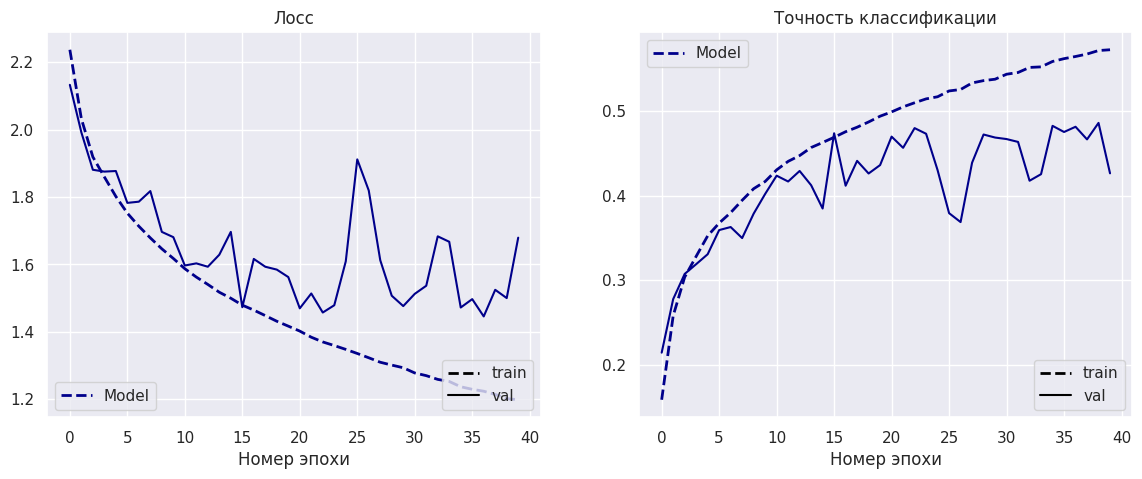

In [24]:
# Кросс-энтропия - общепринятый лосс для классификации
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simple_mlp.parameters(), lr=0.01)

history_mlp = train(simple_mlp, criterion, optimizer, train_batch_gen, val_batch_gen)
# Сохраняем веса модели в файл, чтобы ее потом можно было подгрузить
torch.save(simple_mlp.state_dict(), "simple_mlp.pth")

Как видим, модель MLP правильно предсказывает класс из возможных 10 примерно 50% случаев. Можно ли лучше?

<a name="cnn"></a>
#### 3.5. Свёрточная нейросеть

**Свёрточная нейросеть (CNN)** &mdash; это многослойная нейросеть, имеющая в своей архитектуре свёрточные и pooling-слои.

Простые свёрточные нейросети для классификации почти всегда строятся по следующему правилу:

$$INPUT \longrightarrow \underbrace{\bigg[\big[CONV \to RELU\big]^N \to POOL\:?\bigg]^M}_{\text{Feature extractor}} \longrightarrow \underbrace{\big[FC \to RELU\big]^K}_{\text{Classifier}} \longrightarrow FC,$$
где $CONV$ — сверточные слои, $FC$ — полносвязные слои, а символом "`?`" обозначены опциональные слои.


Поясним схему:
1. Вход &mdash; это batch картинок размера $C \times H \times W$, где $C$ — количество каналов, $H$ — высота изображения, а $W$ — его ширина.

2. **Feature extractor** &mdash; последовательность сверточных и pooling-слоев (convolution + pooling layers). Он предназначен для распознавания сложных паттернов в изображениях и преобразования их в вектор, который содержит всю необходимую информацию о найденных паттернах. Таким образом, мы значительно сокращаем размерность исходного изображения, оставляя только ключевые элементы, важные для классификации.

3. **Classifier** принимает вектор-представление изображения, полученное на выходе из feature extractor-а, и выдает 10 логитов, соответствующих каждому классу. Логиты представляют собой вещественные числа, к которым можно применить `torch.softmax()`, чтобы получить вероятность принадлежности к тому или иному классу.

*Рекомендации:*
  
* Лучше использовать несколько сверток с небольшим ядром, вместо одной свертки с большим ядром. Глубина сети позволяет увеличить сложность распознаваемых паттернов, что в свою очередь повышает качество классификации.

* Pooling &mdash; основной инструмент для уменьшения размерности, что приводит к снижению вычислительной сложности и помогает избежать переобучения модели.

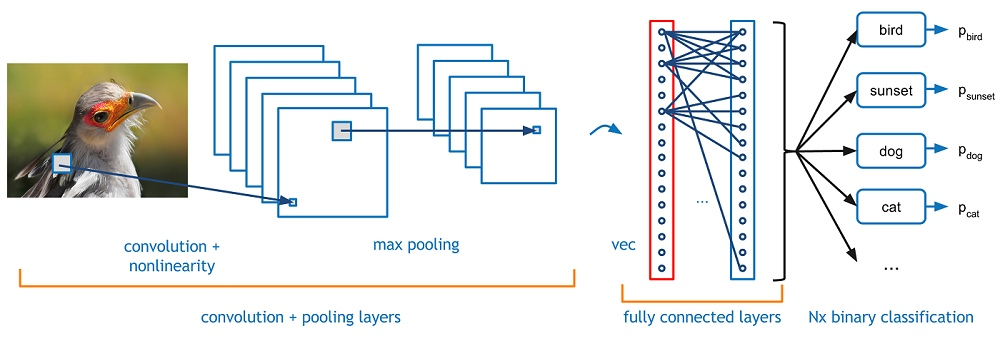

Посмотрим также на реализацию сверточных слоев и слоев пуллинга.

[`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

> **Параметры:**
> - **`in_channels`** (int) — количество каналов во входном изображении.
> - **`out_channels`** (int) — количество каналов после применения свертки (количество фильтров, которые будут применены).
> - **`kernel_size`** (int, tuple) — размер сверточного ядра.
> - **`stride`** (int, tuple) — шаг, с которым будет применена свертка. По умолчанию равен 1.
> - **`padding`** (int, tuple) — добавление по краям изображения дополнительных пикселей. По умолчанию равен 0.


[`nn.MaxPool2d(kernel_size, stride=None)`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Параметры:**
> - **`kernel_size`** (int, tuple) — размер окна, из которого берется максимум.
> - **`stride`** (int, tuple) — шаг, с которым двигается окно. Если не указан, по умолчанию равен `kernel_size`.

---

Подберем архитектуру CNN так, **чтобы количество параметров было примерно таким же, как в MLP** (полносвязная нейросеть). Иначе сравнение было бы нечестным: сеть с б*ó*льшим количеством параметров имела бы преимущество.

In [25]:
simple_cnn = nn.Sequential(
    # Feature extractor
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    # Classifier
    nn.Linear(in_features=2304, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

Проверим количество параметров. Напомним, для MLP было 604 778 параметров.

In [26]:
summary(simple_cnn, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 30, 30]           896
├─MaxPool2d: 1-2                         [1, 32, 15, 15]           --
├─ReLU: 1-3                              [1, 32, 15, 15]           --
├─Conv2d: 1-4                            [1, 64, 13, 13]           18,496
├─MaxPool2d: 1-5                         [1, 64, 6, 6]             --
├─ReLU: 1-6                              [1, 64, 6, 6]             --
├─Flatten: 1-7                           [1, 2304]                 --
├─Linear: 1-8                            [1, 256]                  590,080
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 612,042
Trainable params: 612,042
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.52
Input size (MB): 0.01
Forward/

Обучим CNN:

Эпоха 40 из 40, затраченное время 9.511 сек.
  лосс на обучении: 	0.425034
  лосс на валидации: 	1.255673
  точность на обучении: 		85.80 %
  точность на валидации: 		62.70 %


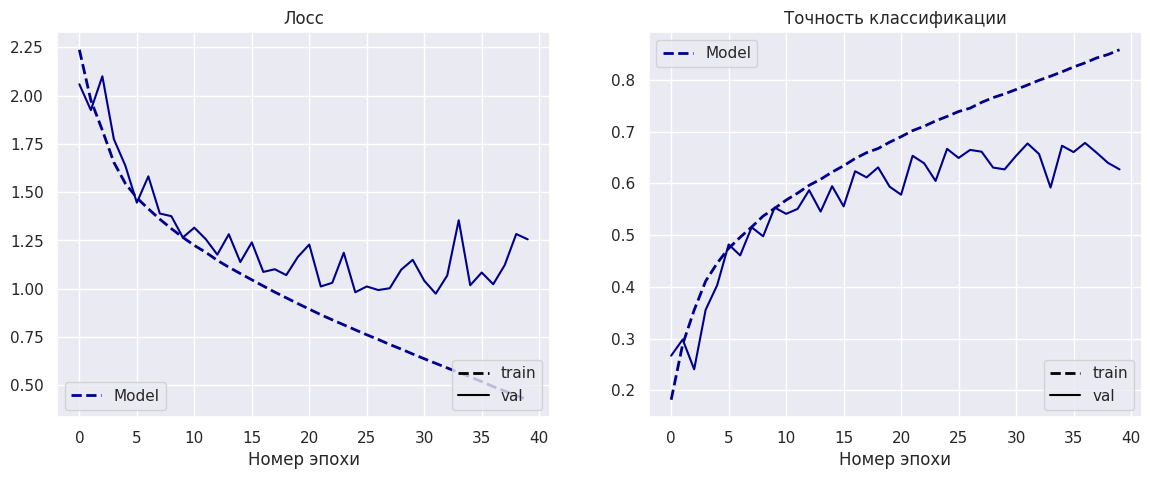

In [27]:
# Кросс-энтропия - общепринятый лосс для классификации
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simple_cnn.parameters(), lr=0.01)

history_cnn = train(
    simple_cnn,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
)
# Сохраняем веса модели в файл, чтобы ее потом можно было подгрузить
torch.save(simple_cnn.state_dict(), "simple_cnn.pth")

Сравним историю обучения обоих сетей

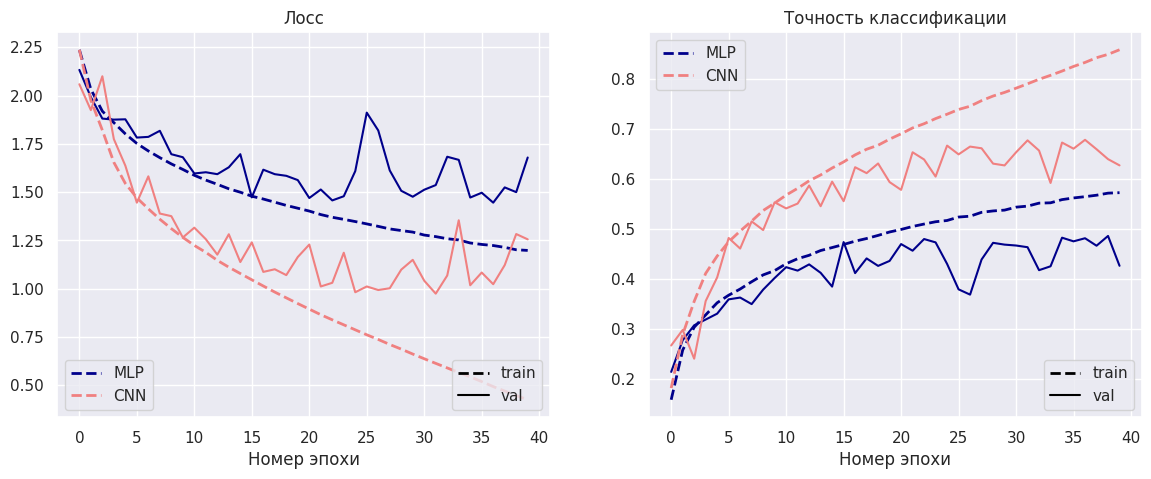

In [28]:
plot_histories([history_mlp, history_cnn], ["MLP", "CNN"])

Мы смогли достичь лучшего качества на тесте, чем MLP.

Обратим внимание на интересный эффект, который можно заметить на графике справа: несмотря на то, что точность продолжает расти на train датасете, она перестает улучшаться на тесте. Эта проблема называется *переобучением нейросети*, и говорит о том, что модель слишком сильно подстраивается под данные, которые видит во время обучения, и перестает улучшать свою обобщающую способность. Особенно сильно переобучаются модели с большим количеством параметров. *Существует множество способов борьбы с этим, подробнее &mdash; на 3 курсе.*


#### 3.6. Визуализация предсказаний

Ранее мы сохранили веса нейросетей в файлы. При необходимости загрузим их

In [29]:
# Если нужно загрузить модели из файла
simple_mlp.load_state_dict(torch.load("simple_mlp.pth", map_location=torch.device(device)))
simple_cnn.load_state_dict(torch.load("simple_cnn.pth", map_location=torch.device(device)))
simple_mlp.eval()
simple_cnn.eval();

Наконец, посмотрим на сами предсказания!

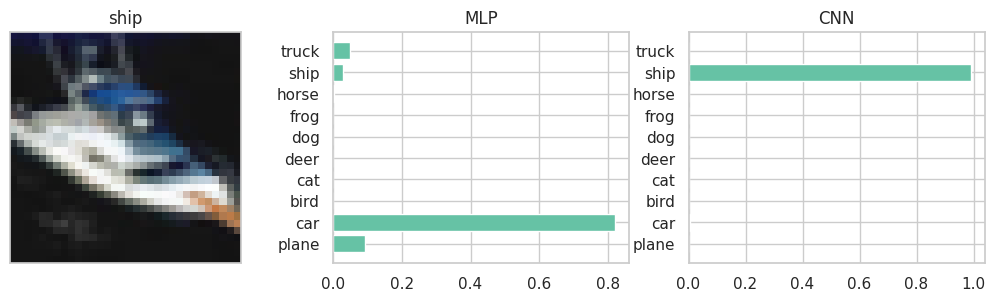

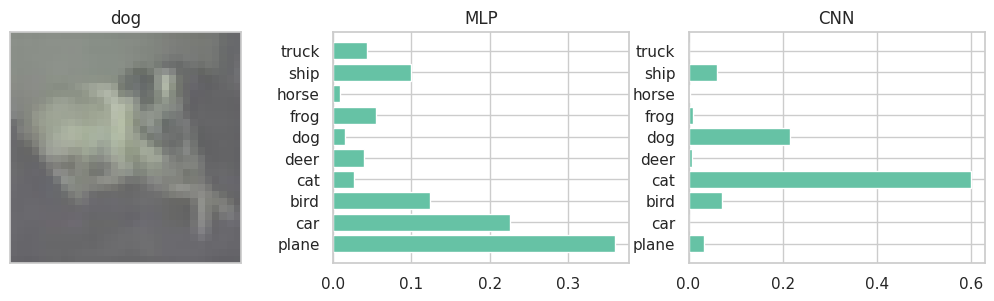

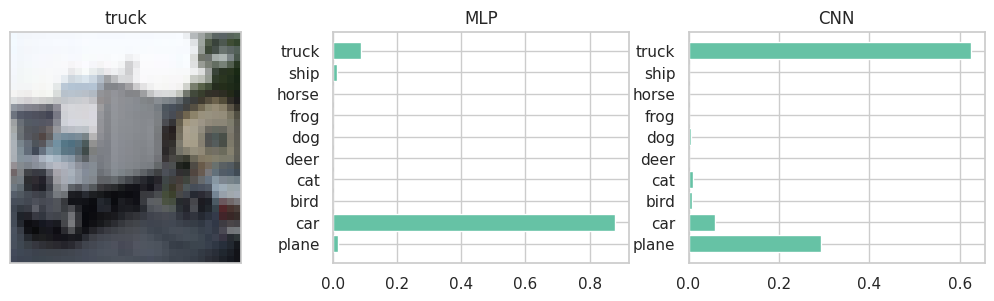

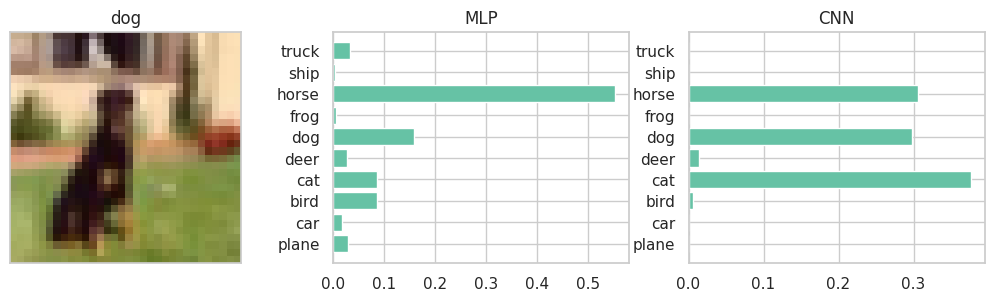

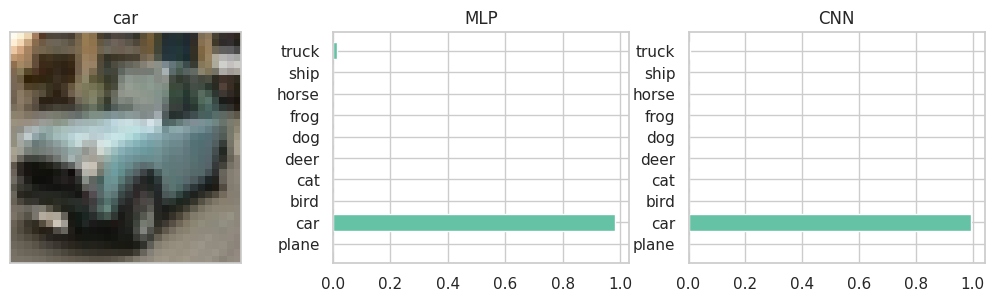

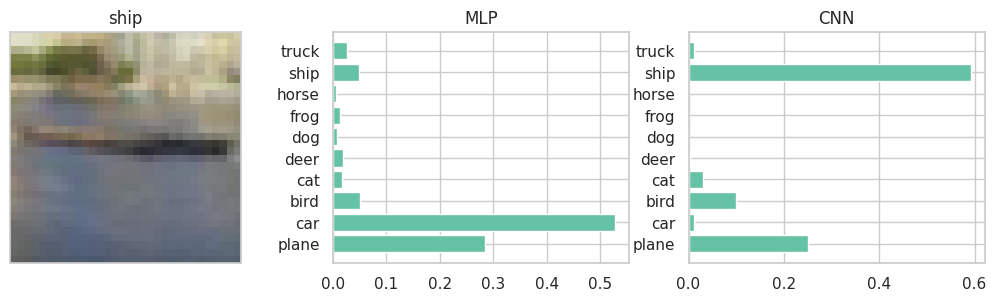

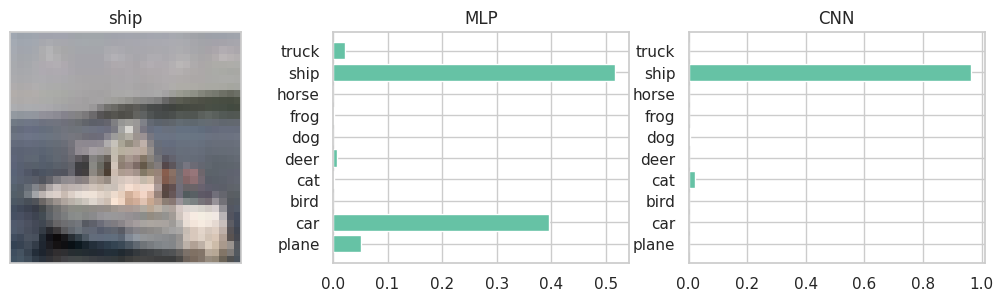

In [30]:
num_test_example = 7

for i in np.random.randint(0, len(val_dataset), num_test_example):
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(13, 3))

        # Достаем 1 рандомный объект из тестового датасета
        image, label = val_dataset[i]

        plt.subplot(1, 3, 1)
        plt.imshow(image.permute((1, 2, 0)))
        plt.title(classes[label])
        plt.xticks([])
        plt.yticks([])

        # Не забываем выключить градиенты на момент вычислений
        with torch.no_grad():
            logits_mlp = simple_mlp(image.to(device).unsqueeze(0))[0].cpu()
            logits_cnn = simple_cnn(image.to(device).unsqueeze(0))[0].cpu()

        # Чтобы логиты перевести в вероятности применяем softmax по оси классов
        prob_mlp = torch.softmax(logits_mlp, dim=0)
        prob_cnn = torch.softmax(logits_cnn, dim=0)

        plt.subplot(1, 3, 2)
        plt.barh(classes, prob_mlp)
        plt.title("MLP")

        plt.subplot(1, 3, 3)
        plt.barh(classes, prob_cnn)
        plt.title("CNN")

**Вывод:** Обе модели не являются совершенными: на некоторых сложных изображениях они могут ошибаться. Однако CNN демонстрирует большую уверенность в своих предсказаниях, в то время как MLP часто предлагает одинаковые вероятности для нескольких объектов.

#### 3.7. Применение VGG для классификации

Для классификации изображений не обязательно всегда самостоятельно писать нейросети. Можно воспользоваться предобученными моделями.

Загрузим предобученную VGG16

In [31]:
vgg16 = models.vgg16(pretrained=True)
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 149MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Адаптируем модель для нашей задачи классификации CIFAR10. Для этого мы заменим последний полносвязный слой модели

`Linear(in_features=4096, out_features=1000, bias=True)`

на новый, соответствующий числу классов в CIFAR10 (10 классов).

In [32]:
vgg16.classifier[6] = nn.Linear(4096, 10)

Перенесем модель на доступное устройство

In [33]:
vgg16 = vgg16.to(device)

Необходимо изменить предобработку изображений, так как VGG ожидает изображения большего размера (224x224) и нормированные определенным образом

In [34]:
transform_for_vgg = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

Создаем новые датасеты с нужной предобработкой

In [35]:
train_dataset_vgg = torchvision.datasets.CIFAR10(
    root="./cifar", download=True, train=True, transform=transform_for_vgg
)

val_dataset_vgg = torchvision.datasets.CIFAR10(
    root="./cifar", download=True, train=False, transform=transform_for_vgg
)

Генераторы батчей

In [36]:
batch_size_vgg = 32  # уменьшаем размер батча из-за увеличения размера изображений

train_batch_gen_vgg = torch.utils.data.DataLoader(
    train_dataset_vgg, batch_size=batch_size_vgg, shuffle=True
)
val_batch_gen_vgg = torch.utils.data.DataLoader(
    val_dataset_vgg, batch_size=batch_size_vgg, shuffle=False
)

Выведем информацию о модели

In [37]:
summary(vgg16, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [38]:
sum(p.numel() for p in vgg16.features.parameters())
sum(p.numel() for p in vgg16.classifier.parameters())

119586826

Для ускорения обучения заморозим веса большей части модели и будем обучать только последние слои

In [39]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [40]:
print("Параметры модели, которые будут обучаться:")
trainable_params = [name for name, param in vgg16.named_parameters() if param.requires_grad]

print(f"Всего обучаемых параметров: {len(trainable_params)}")
print("Пример обучаемых слоев:", trainable_params[: len(trainable_params)])

Параметры модели, которые будут обучаться:
Всего обучаемых параметров: 6
Пример обучаемых слоев: ['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']


Настраиваем функцию потерь и оптимизатор, обучаем только незамороженные параметры

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    [p for p in vgg16.parameters() if p.requires_grad], lr=0.001, momentum=0.9
)

Обучаем модель (для быстроты на нескольких эпохах)

Эпоха 5 из 5, затраченное время 395.068 сек.
  лосс на обучении: 	0.154756
  лосс на валидации: 	0.350110
  точность на обучении: 		94.60 %
  точность на валидации: 		88.52 %


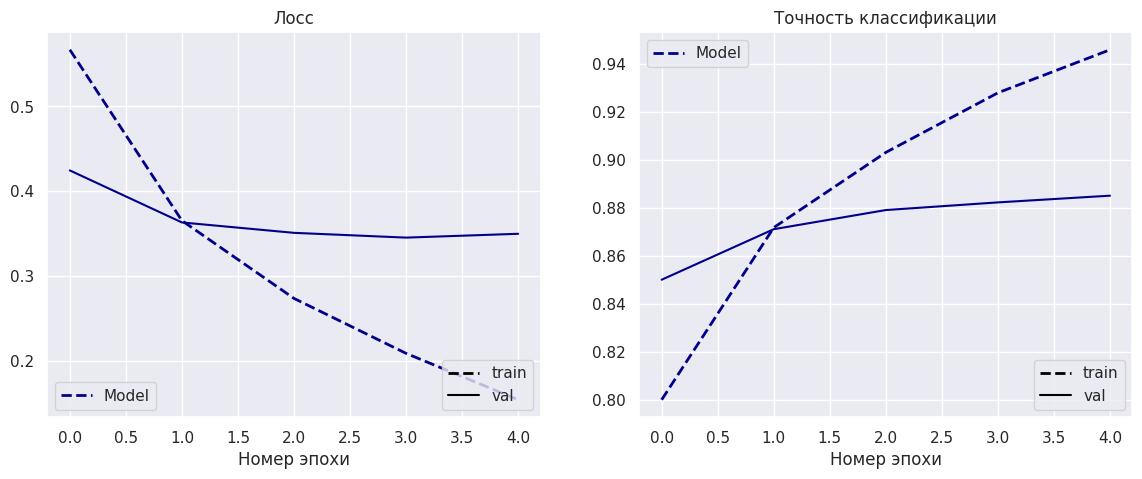

In [42]:
num_epochs = 5  # уменьшаем количество эпох, так как VGG - большая модель

history_vgg = train(
    vgg16, criterion, optimizer, train_batch_gen_vgg, val_batch_gen_vgg, num_epochs=num_epochs
)

Сохраняем модель в файл

In [43]:
torch.save(vgg16.state_dict(), "vgg16_cifar10.pth")

Сравниваем результаты

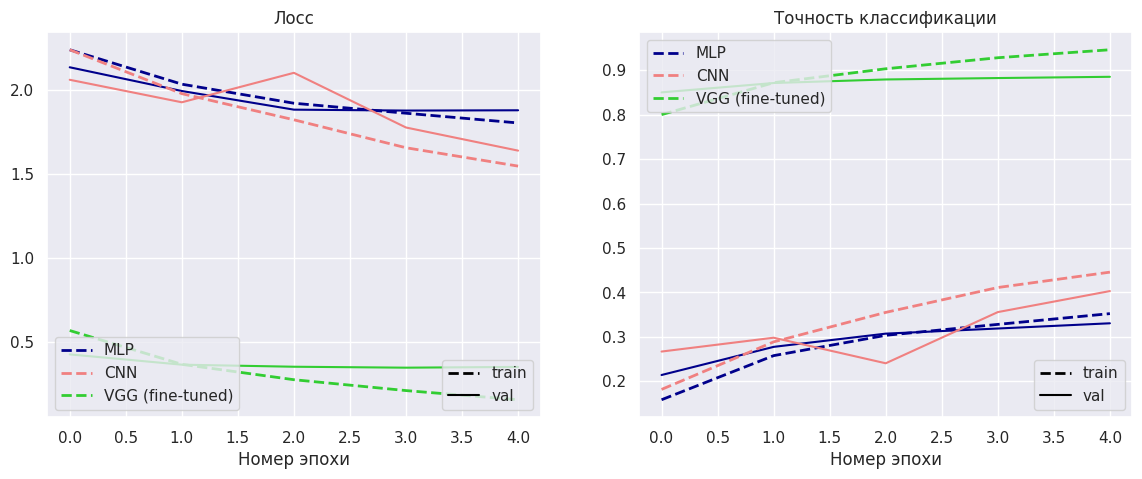

In [44]:
plot_histories([history_mlp, history_cnn, history_vgg], ["MLP", "CNN", "VGG (fine-tuned)"])

Видим, что с первых же итераций VGG оказалась сильно лучше MLP и CNN.
Если мы посмотрим на предыдущие графики, мы сможем увидеть, что результаты наших моделей MLP и CNN даже после 40 итераций не превзошли VGG.

Теперь визуализируем предсказания VGG и сравним с другими моделями

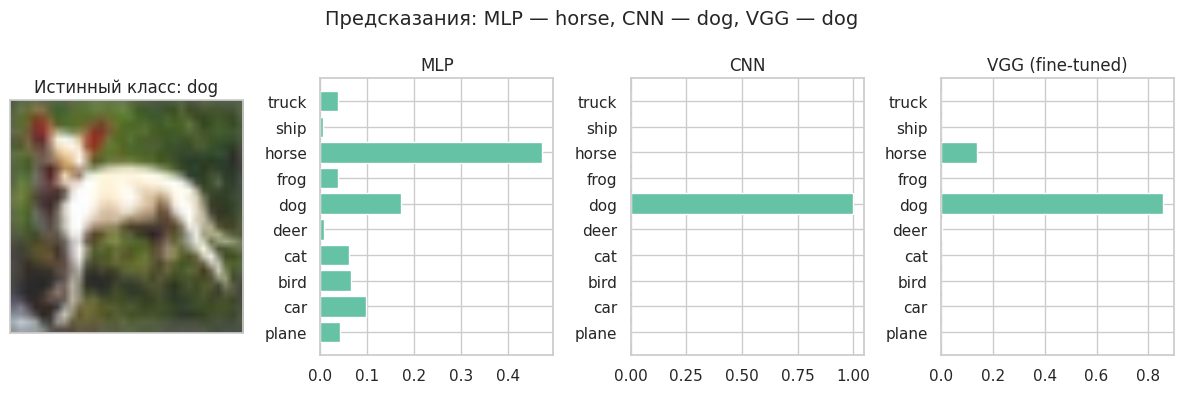

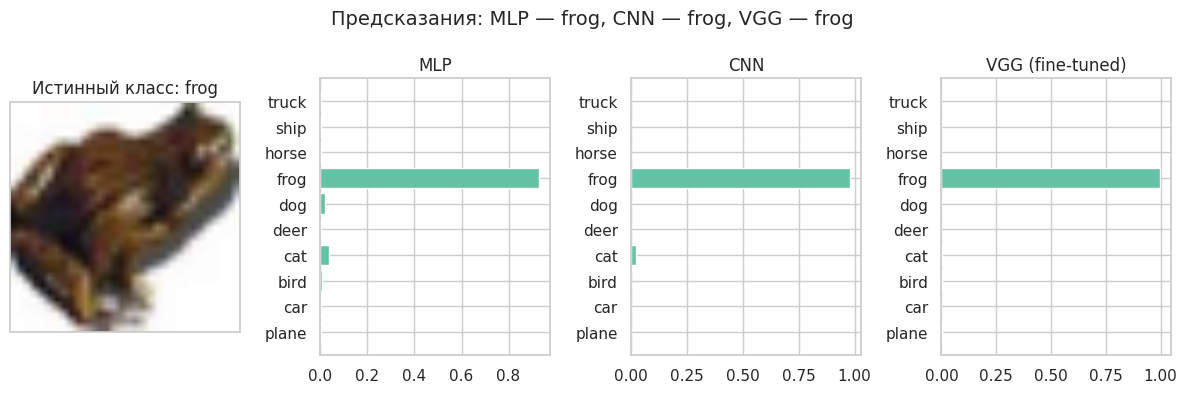

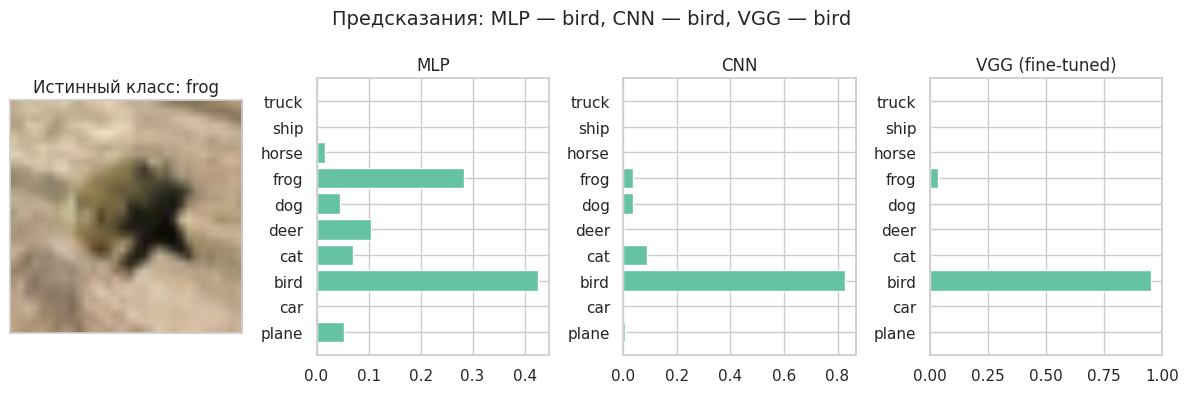

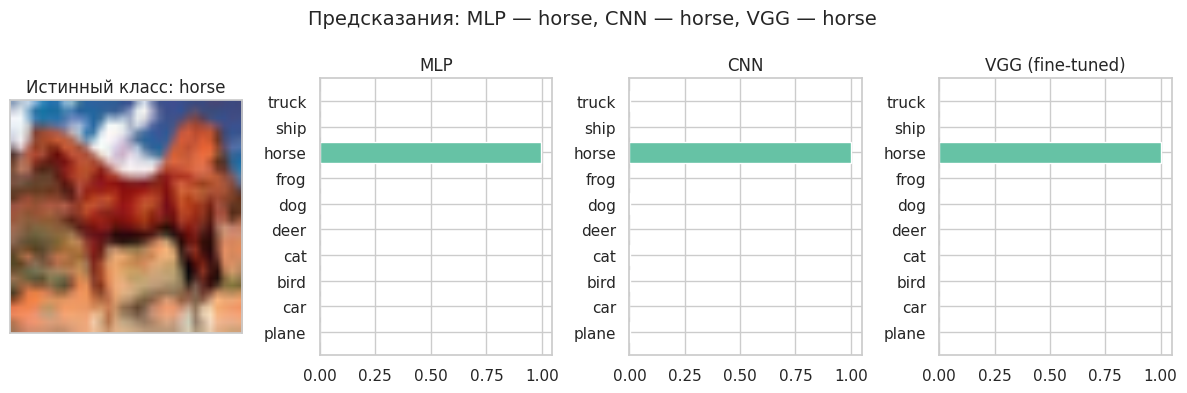

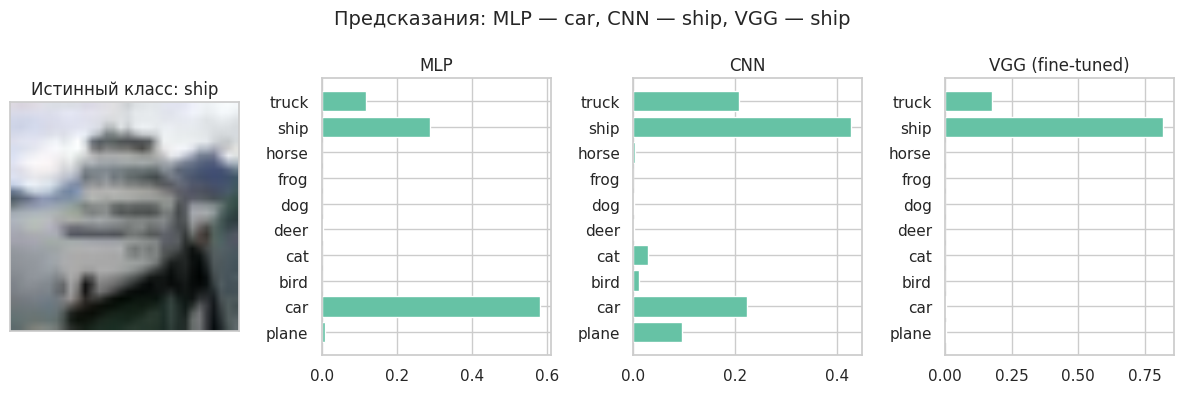

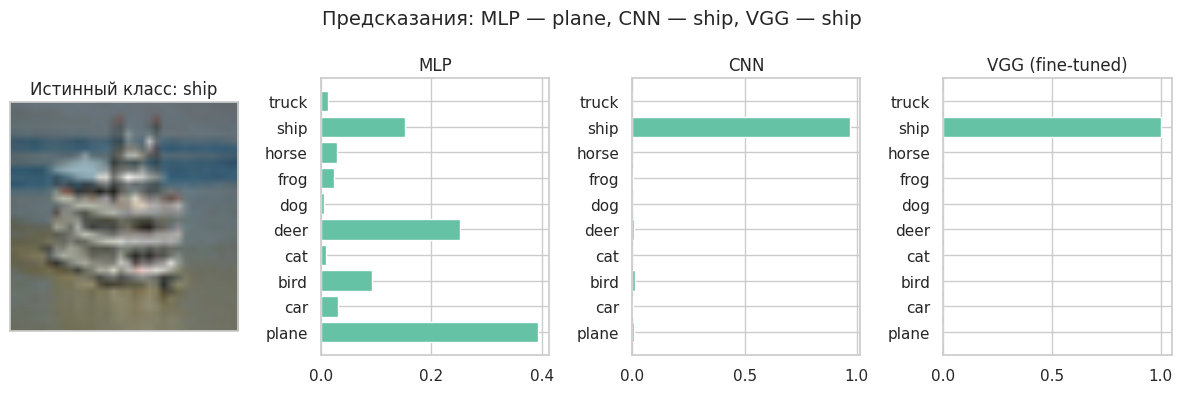

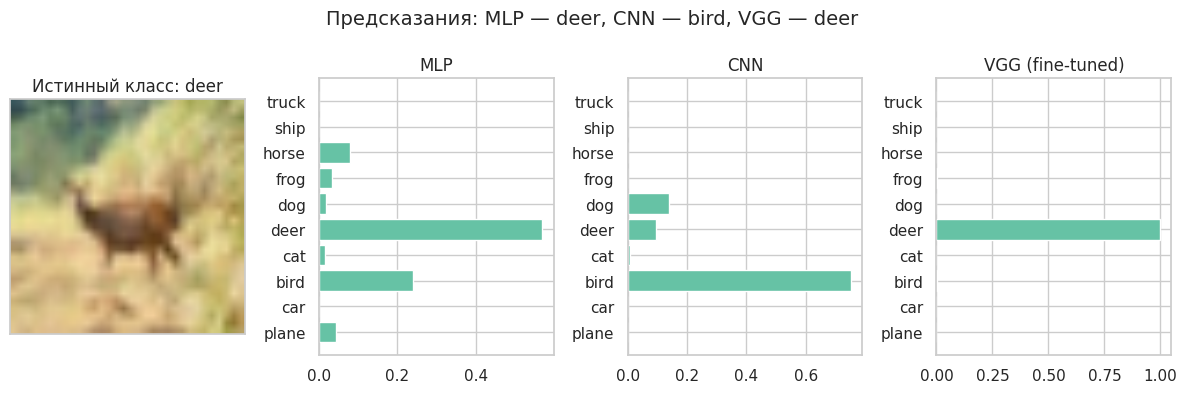

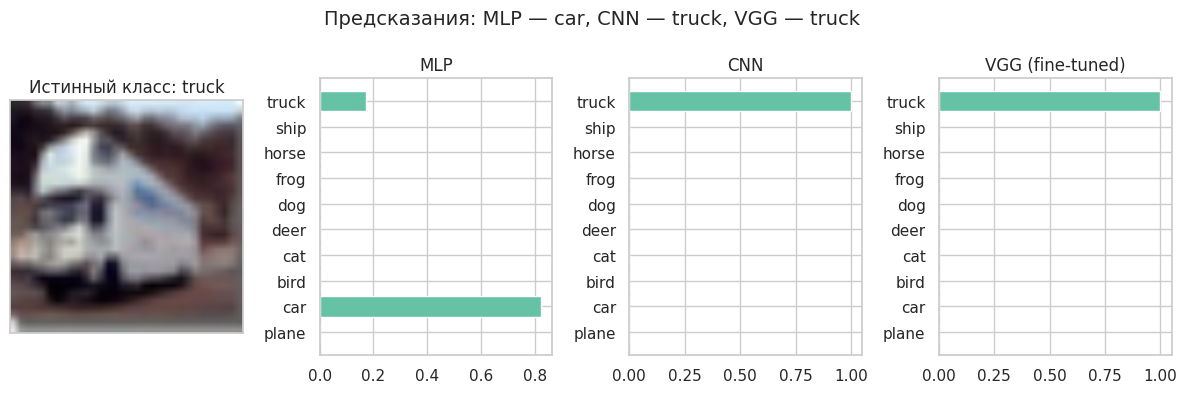

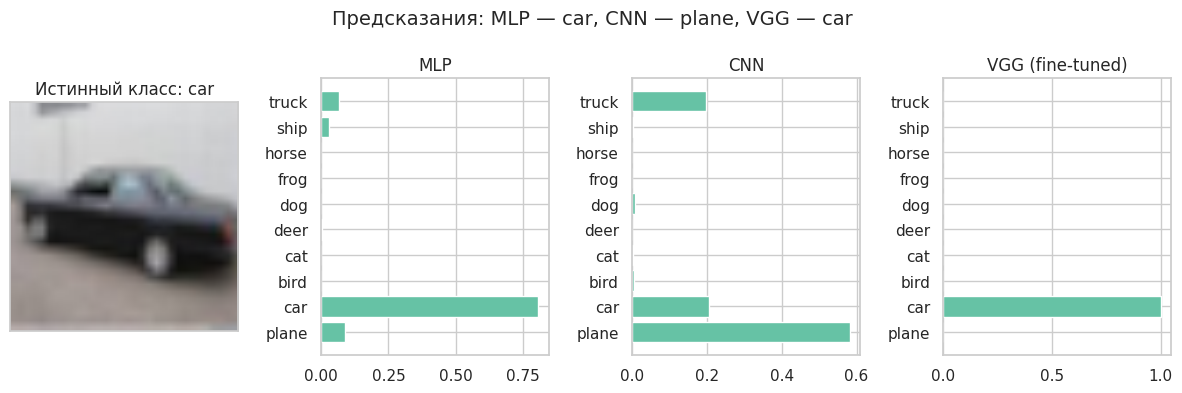

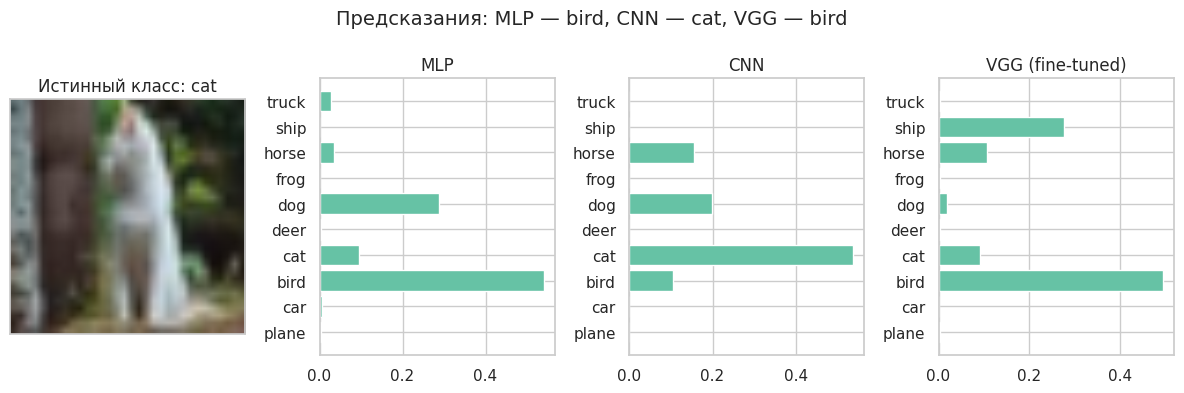

In [45]:
num_test_example = 10

for i in np.random.randint(0, len(val_dataset_vgg), num_test_example):
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(12, 4))

        # Получаем изображение из датасета
        image, label = val_dataset_vgg[i]

        # Отображаем изображение
        plt.subplot(1, 4, 1)

        # Нужно денормализовать изображение для отображения
        denorm_image = image.clone()
        denorm_image[0] = denorm_image[0] * 0.229 + 0.485
        denorm_image[1] = denorm_image[1] * 0.224 + 0.456
        denorm_image[2] = denorm_image[2] * 0.225 + 0.406
        plt.imshow(denorm_image.permute((1, 2, 0)).clamp(0, 1))
        plt.title(f"Истинный класс: {classes[label]}")
        plt.xticks([])
        plt.yticks([])

        # Получаем предсказания от всех моделей
        with torch.no_grad():
            # Для MLP и CNN нужно преобразовать изображение обратно к размеру 32x32
            small_image = F.interpolate(image.unsqueeze(0), size=(32, 32), mode="bilinear")[0]

            # Для корректной работы с MLP и CNN, нужно отменить нормализацию, и выполнить обычную для них
            small_image = small_image * torch.tensor([0.229, 0.224, 0.225]).view(
                3, 1, 1
            ) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

            # Предсказания моделей
            logits_mlp = simple_mlp(small_image.to(device).unsqueeze(0))[0].cpu()
            logits_cnn = simple_cnn(small_image.to(device).unsqueeze(0))[0].cpu()
            logits_vgg = vgg16(image.to(device).unsqueeze(0))[0].cpu()

            # Преобразуем логиты в вероятности
            prob_mlp = torch.softmax(logits_mlp, dim=0)
            prob_cnn = torch.softmax(logits_cnn, dim=0)
            prob_vgg = torch.softmax(logits_vgg, dim=0)

            # Отображаем вероятности для каждой модели
            plt.subplot(1, 4, 2)
            plt.barh(classes, prob_mlp)
            plt.title("MLP")

            plt.subplot(1, 4, 3)
            plt.barh(classes, prob_cnn)
            plt.title("CNN")

            plt.subplot(1, 4, 4)
            plt.barh(classes, prob_vgg)
            plt.title("VGG (fine-tuned)")

            # Выводим предсказания моделей
            pred_mlp = classes[prob_mlp.argmax().item()]
            pred_cnn = classes[prob_cnn.argmax().item()]
            pred_vgg = classes[prob_vgg.argmax().item()]

            plt.suptitle(
                f"Предсказания: MLP — {pred_mlp}, CNN — {pred_cnn}, VGG — {pred_vgg}", fontsize=14
            )

        plt.tight_layout()
        plt.show()

Видим, что у VGG выше уверенность в предсказаниях и они точнее.

**Вывод:**

Преимущество использования предобученных моделей, таких как VGG, заключается в том, что они уже научились извлекать полезные признаки из изображений на больших наборах данных. Мы можем использовать transfer learning, замораживая большую часть слоев и дообучая только последние, чтобы адаптировать модель к нашей конкретной задаче.

Этот подход значительно повышает точность классификации даже на небольших наборах данных, как мы видим, сравнивая результаты VGG с более простыми моделями MLP и CNN.

---

<a href="https://thetahat.ru/files/ad/main/5/cv_complex_examples" target="_blank">Во второй части</a> мы посмотрим на примеры обученных сетей для переноса стиля и генерации изображений по промпту